# Denoising of radio traces

A promising approach for the measurement of ultra-high-energy neutrinos is the detection via their radio emission when interacting in the atmosphere. By connecting many radio antennas, radio arrays are constructed that are supposed to extend over hundreds of square kilometers to obtain sufficient exposure for successfully detecting these rare cosmic messengers. For accurate measurements, the antennas have to be placed in a radio-quiet environment, like Greenland, where the background noise is small. However, the size of the noise can still significantly disturb the measurement.
Therefore, the reduction of this noise in neutrino measurements will be investigated in the following project.

Given are 25000 simulated neutrino signals and realistic background measured at Greenland. In order to achieve an accurate reconstruction, we will try to filter the signals to remove the interfering background.

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

### Load data from hdf.5 files

In [2]:
f_noise = h5py.File("./noise.hdf5")
f_signal = h5py.File("./simulation.hdf5")

In [3]:
noise = f_noise["traces [mV]"][:]
time_noise = f_noise["times [ns]"][:]

signal = f_signal["traces [mV]"][:]
time_signal = f_signal["times [ns]"][:]

### Plot example traces

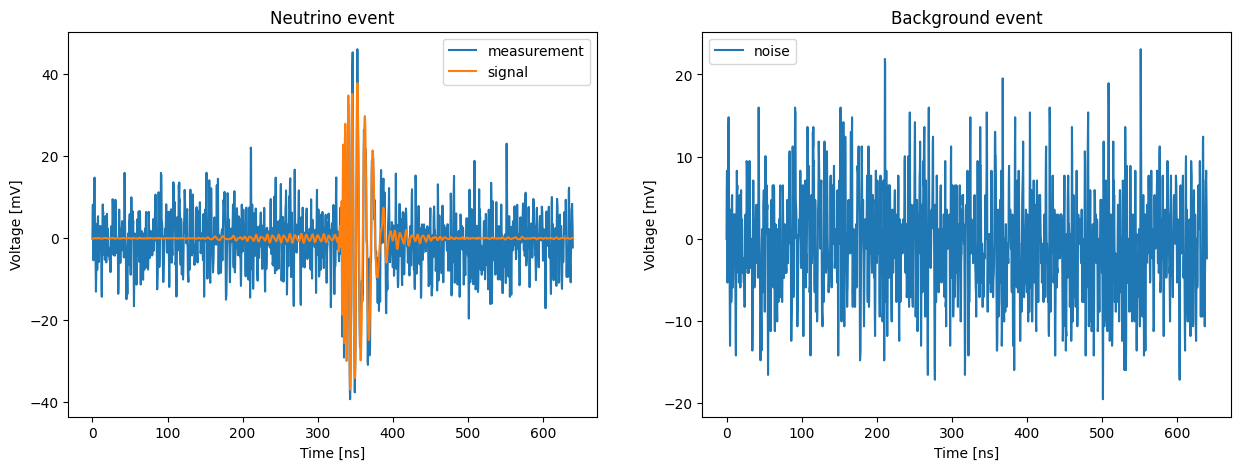

In [4]:
idx = 1
times = np.linspace(0, 640, 2048)
plt.figure(1, (15, 5))
plt.subplot(1, 2, 1)
plt.plot(time_noise[idx], noise[idx] + signal[idx], label="measurement")
plt.plot(time_noise[idx], signal[idx], label="signal")
plt.ylabel("Voltage [mV]")
plt.xlabel("Time [ns]")
plt.title("Neutrino event")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(times, noise[idx], label="noise")
plt.ylabel("Voltage [mV]")
plt.xlabel("Time [ns]")
plt.title("Background event")
plt.legend()

plt.savefig("signal_noise.png", bbox_inches="tight")
plt.show()

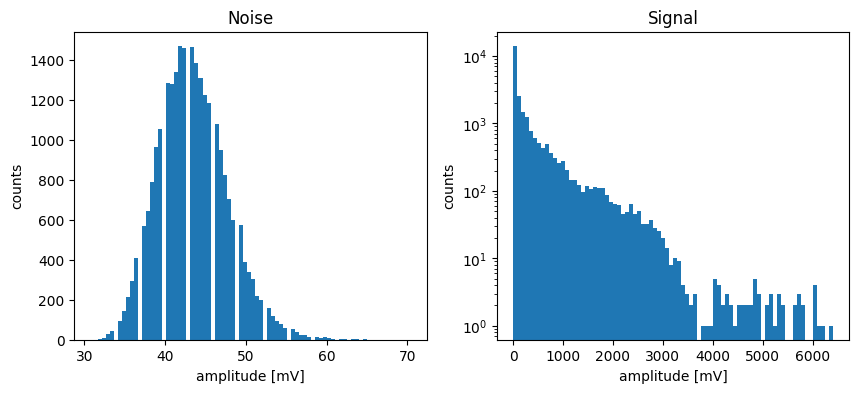

In [5]:
# investigate data: plot histograms of maximal peak-to-peak amplitude for noise and signals, respectively

noise_A = [(max(x) + abs(min(x))) for x in noise]

signal_A = [(max(x) + abs(min(x))) for x in signal]

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].hist(noise_A, bins=80)
ax[0].set_xlabel("amplitude [mV]")
ax[0].set_ylabel("counts")
ax[0].set_title("Noise")
ax[1].hist(signal_A, bins=80, log=True)
ax[1].set_xlabel("amplitude [mV]")
ax[1].set_ylabel("counts")
ax[1].set_title("Signal")

fig.savefig("Signal_Noise_Amplitude.png", bbox_inches='tight')

To create the measurement of the detector, simply the sum of the recorded noise is added to the simulated neutrino signal.

In [22]:
# function for measuring position, duration and amplitude of pulse

def measure_pulse(pulse,time):
    
    # amplitude peak to peak
    amplitude = max(pulse) + abs(min(pulse))
    
    begin = 0
    end = 0
    
    # duration begins and ends at 1/e of amplitude above zero
    threas = (max(pulse))/np.e

    for i in range(len(pulse)):
        if pulse[i] >= threas:
            begin = i
            break
    for j in reversed(range(len(pulse))):
        if pulse[j] >= threas:
            end = j
            break
    
    duration = time[end] - time[begin]
    
    # position of center
    position = time[begin] + (time[end] - time[begin])/2
    
    return position, duration, amplitude

In [7]:
# example measurement

measure_pulse(signal[1],times)

(354.2354665363947, 40.64484611626767, 74.75151084247557)

In [8]:
# function for generating training data (measurement = signal + noise), validation data and test data
# split should be 1/2, 1/4, 1/4

def generate_data(signal,noise):
    
    # shuffle noise and signal to recieve different signal/noise combos with each function call
    
    np.random.shuffle(signal)
    np.random.shuffle(noise)
    
    # split data set into half train and half other data
    
    mask = np.random.rand(signal.shape[0]) <= 0.5

    train_data = signal[mask] + noise[mask]
    other_data = signal[~mask] + noise[~mask]

    train_label = signal[mask]

    # split other data again in half test and half validation data

    mask2 = np.random.rand(other_data.shape[0]) <= 0.5

    val_data = signal[~mask][mask2] + noise[~mask][mask2]
    test_data = signal[~mask][~mask2] + noise[~mask][~mask2]

    val_label = signal[~mask][mask2]
    test_label = signal[~mask][~mask2]
    
    return [[train_data, train_label],[val_data, val_label],[test_data, test_label]]


In [9]:
# generate two datasets

data1 = generate_data(signal,noise)
data2 = generate_data(signal,noise)

In [10]:
# define train, validation and test data from both datasets

train_data = np.concatenate((data1[0][0], data2[0][0]), axis=0)
train_label = np.concatenate((data1[0][1], data2[0][1]), axis=0)
val_data = np.concatenate((data1[1][0], data2[1][0]), axis=0)
val_label = np.concatenate((data1[1][1], data2[1][1]), axis=0)
test_data = np.concatenate((data1[2][0], data2[2][0]), axis=0)
test_label = np.concatenate((data1[2][1], data2[2][1]), axis=0)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(25464, 2048)
(12921, 2048)
(12815, 2048)


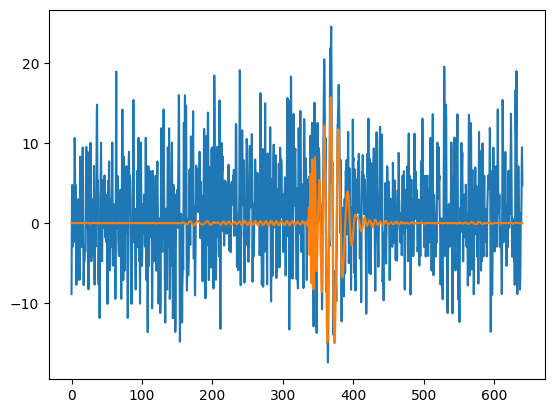

In [11]:
# example measurement and label

plt.figure()
plt.plot(times,test_data[1])
plt.plot(times,test_label[1])
plt.show()

In [12]:
# import all important fuctions from keras

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K

In [28]:
class ConvAutoencoder:
    
    @staticmethod
    
    # build input time signal with variable length
    def build(length, filters=(32, 64), latentDim=20):
        
        # Conv1D requires input shape of (sequence length, vector-dim)
        inputShape = (length, 1)
        
        # Input: instantiate Keras tensor for input into Model
        inputs = Input(shape=inputShape)
        x = inputs
        
        # stride=2 -> filter moves 2 data points at a time (like data compression)
        # padding="same": padding with zeros evenly to left and right
        # axis -1 of x is feature axis -> normalize features
        
        # loop over filters
        for f in filters:
            
            # CONV -> RELU operation of input x
            x = Conv1D(f, kernel_size=3, strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
    
        # flatten network and construct latent vector
        # backend.int_shape: returns shape of tensor as touple
        volumeSize = K.int_shape(x)
        # store volume size to reshape tensor after latent vector
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
        # build encoder
        # Model: groups layers into an object with training and inference features
        encoder = Model(inputs, latent, name="encoder")
        
        # encoder output into latentInputs
        # Latent space -> compressed representation of data
        latentInputs = Input(shape=(latentDim,))
        # np.prod: product of array elements over given axis
        # volumeSize[0] is "None"
        # reshape latent vector into tensor size that it was before
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2]))(x)
        
        # loop over filters in reverse order
        for f in filters[::-1]:
            
            # CONV_TRANSPOSE -> RELU operation of input x
            x = Conv1DTranspose(f, kernel_size=3, strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
        
        # reshape into output shape
        x = Conv1DTranspose(1,1,strides=1, padding="same")(x)
        outputs = Activation("linear")(x)
        
        # build decoder (takes output of encoder as input)
        decoder = Model(latentInputs, outputs, name="decoder")
        
        # autoencoder = encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
        
        # return 3-touple
        return (encoder, decoder, autoencoder)
    

In [29]:
# initialize autoencoder

epochs = 50
batch_size = 2000
learning_rate = 0.01

(encoder, decoder, autoencoder) = ConvAutoencoder.build(signal.shape[1])
opt = Adam(learning_rate=learning_rate)
autoencoder.compile(loss="mse", optimizer=opt, metrics=['mse'])

In [30]:
# more information on model

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2048, 1)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1024, 32)          128       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1024, 32)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 512, 64)           6208      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512, 64)           0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 20)                6553

In [17]:
# train autoencoder

H = autoencoder.fit(
    train_data, train_label,
    validation_data=(val_data, val_label),
    epochs=epochs,
    batch_size=batch_size)

Epoch 1/50
13/13 [==============================] - 59s 5s/step - loss: 1706.5269 - mse: 1706.5269 - val_loss: 708.5890 - val_mse: 708.5890
Epoch 2/50
13/13 [==============================] - 56s 4s/step - loss: 506.9102 - mse: 506.9102 - val_loss: 335.4127 - val_mse: 335.4127
Epoch 3/50
13/13 [==============================] - 52s 4s/step - loss: 275.1313 - mse: 275.1313 - val_loss: 203.2578 - val_mse: 203.2578
Epoch 4/50
13/13 [==============================] - 51s 4s/step - loss: 175.1365 - mse: 175.1365 - val_loss: 137.1075 - val_mse: 137.1075
Epoch 5/50
13/13 [==============================] - 51s 4s/step - loss: 116.2653 - mse: 116.2653 - val_loss: 98.9115 - val_mse: 98.9115
Epoch 6/50
13/13 [==============================] - 51s 4s/step - loss: 86.3004 - mse: 86.3004 - val_loss: 80.5421 - val_mse: 80.5421
Epoch 7/50
13/13 [==============================] - 51s 4s/step - loss: 124.7436 - mse: 124.7436 - val_loss: 79.9573 - val_mse: 79.9573
Epoch 8/50
13/13 [======================

In [23]:
# load model parameters
autoencoder = load_model('myModel_Haefner.h5')

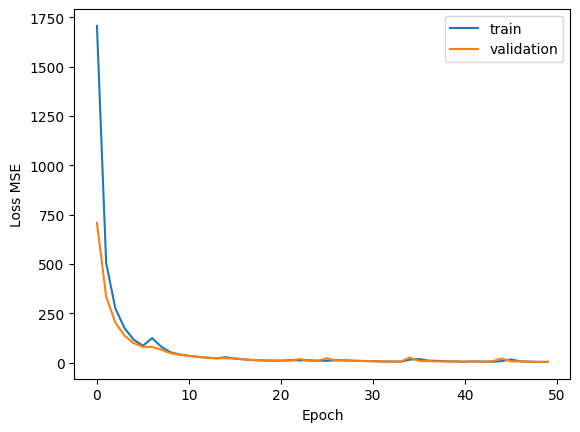

In [19]:
# plot the training and validation loss over all epochs from the keras history module 

plt.figure()
plt.plot(H.history['loss'], label = "train")
plt.plot(H.history['val_loss'], label = "validation")
plt.ylabel('Loss MSE')
plt.xlabel('Epoch')
plt.legend()

plt.savefig("training.png", bbox_inches='tight')
plt.show()

In [24]:
# denoise test measurements with trained autoencoder

prediction = autoencoder.predict(test_data)

401/401 [==============================] - 20s 49ms/step


In [25]:
# split test data into group with signal amplitude < thres and > thres (thres = 30 mV)

# signals > threas:

mask = np.array([(max(x)+abs(min(x))) < 30 for x in test_label])
test_label_above = test_label[~mask]
prediction_above = prediction[~mask]
test_label_below = test_label[mask]
prediction_below = prediction[mask]

signal_meas_above = np.array([measure_pulse(x,times) for x in test_label_above])
prediction_meas_above = np.array([measure_pulse(x,times) for x in prediction_above])

signal_A_above = signal_meas_above[:,2]
prediction_A_above = np.concatenate(prediction_meas_above[:,2])

signal_dur_above = signal_meas_above[:,1]
prediction_dur_above = prediction_meas_above[:,1]

signal_pos_above = signal_meas_above[:,0]
prediction_pos_above = prediction_meas_above[:,0]

# signals < threas:

signal_meas_below = np.array([measure_pulse(x,times) for x in test_label_below])
prediction_meas_below = np.array([measure_pulse(x,times) for x in prediction_below])

signal_A_below = signal_meas_below[:,2]
prediction_A_below = np.concatenate(prediction_meas_below[:,2])

signal_dur_below = signal_meas_below[:,1]
prediction_dur_below = prediction_meas_below[:,1]

signal_pos_below = signal_meas_below[:,0]
prediction_pos_below = prediction_meas_below[:,0]

C:\Users\Juu\AppData\Local\Temp\ipykernel_5764\3649327268.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prediction_meas_above = np.array([measure_pulse(x,times) for x in prediction_above])
C:\Users\Juu\AppData\Local\Temp\ipykernel_5764\3649327268.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prediction_meas_below = np.array([measure_pulse(x,times) for x in prediction_below])


In [21]:
# ratios of amplitudes larger and smaller than threshold in all test signals

print(test_label_above.shape[0]/test_label.shape[0])
print(test_label_below.shape[0]/test_label.shape[0])

0.582052282481467
0.417947717518533


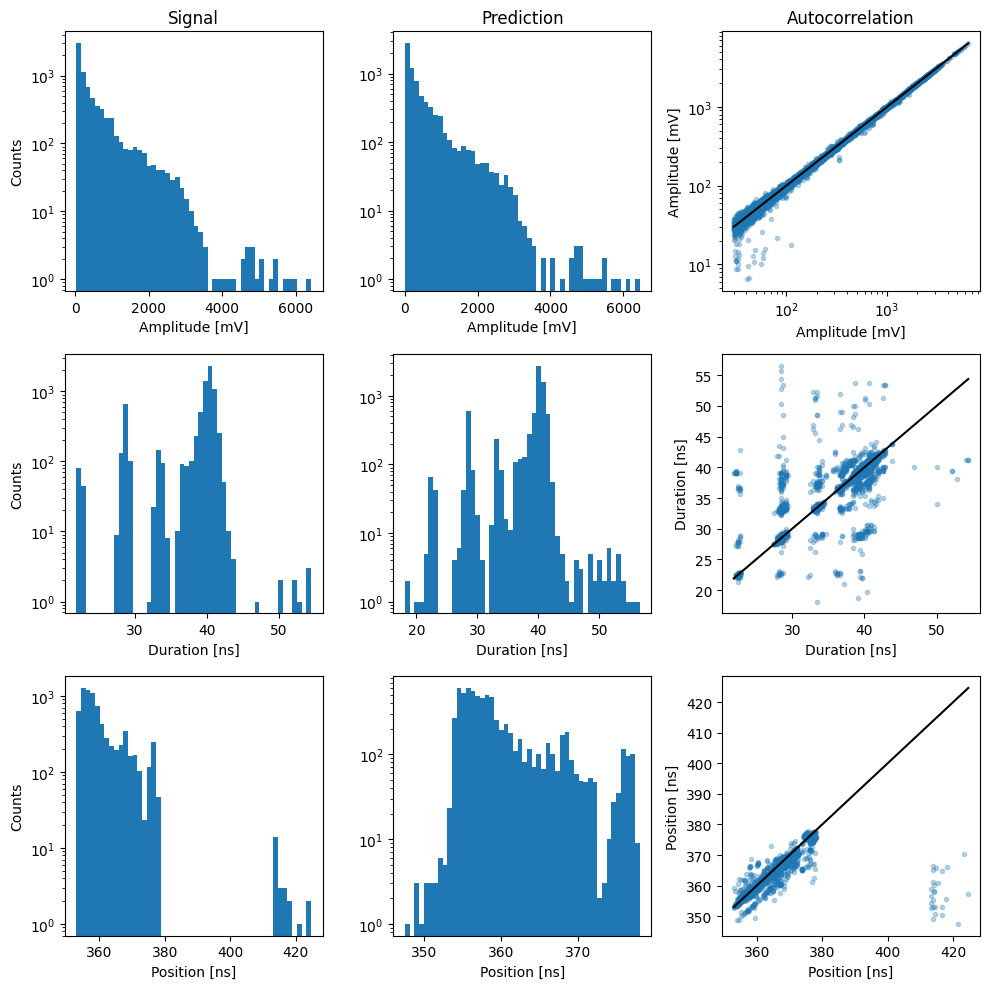

In [26]:
# plot distribution histograms for labels and predictions + auto-correlation for test signals > 30 mV 

xdata1 = np.linspace(min(signal_A_above),max(signal_A_above),1000)
xdata2 = np.linspace(min(signal_dur_above),max(signal_dur_above),1000)
xdata3 = np.linspace(min(signal_pos_above),max(signal_pos_above),1000)

fig, ax = plt.subplots(3,3, figsize=(10,10))

ax[0,0].hist(signal_A_above, bins = 50, log = True)
ax[0,1].hist(prediction_A_above, bins = 50, log = True)
ax[0,2].plot(signal_A_above, prediction_A_above, linestyle = 'None', marker = '.', alpha=0.3)
ax[0,2].plot(xdata1,xdata1,color="k")
ax[0,2].set_xscale("log")
ax[0,2].set_yscale("log")
ax[0,0].set_ylabel("Counts")

ax[1,0].hist(signal_dur_above, bins = 50, log = True)
ax[1,1].hist(prediction_dur_above, bins = 50, log = True)
ax[1,2].plot(signal_dur_above, prediction_dur_above, linestyle = 'None', marker = '.', alpha=0.3)
ax[1,2].plot(xdata2,xdata2,color="k")
ax[1,0].set_ylabel("Counts")

ax[2,0].hist(signal_pos_above, bins = 50, log = True)
ax[2,1].hist(prediction_pos_above, bins = 50, log = True)
ax[2,2].plot(signal_pos_above, prediction_pos_above, linestyle = 'None', marker = '.', alpha=0.3)
ax[2,2].plot(xdata3,xdata3,color="k")
ax[2,0].set_ylabel("Counts")

ax[0,0].set_title("Signal")
ax[0,1].set_title("Prediction")
ax[0,2].set_title("Autocorrelation")
ax[0,0].set_xlabel("Amplitude [mV]")
ax[0,1].set_xlabel("Amplitude [mV]")
ax[0,2].set_xlabel("Amplitude [mV]")
ax[0,2].set_ylabel("Amplitude [mV]")

ax[1,0].set_xlabel("Duration [ns]")
ax[1,1].set_xlabel("Duration [ns]")
ax[1,2].set_xlabel("Duration [ns]")
ax[1,2].set_ylabel("Duration [ns]")

ax[2,0].set_xlabel("Position [ns]")
ax[2,1].set_xlabel("Position [ns]")
ax[2,2].set_xlabel("Position [ns]")
ax[2,2].set_ylabel("Position [ns]")

fig.tight_layout()

fig.savefig("performance_above_threas.png")


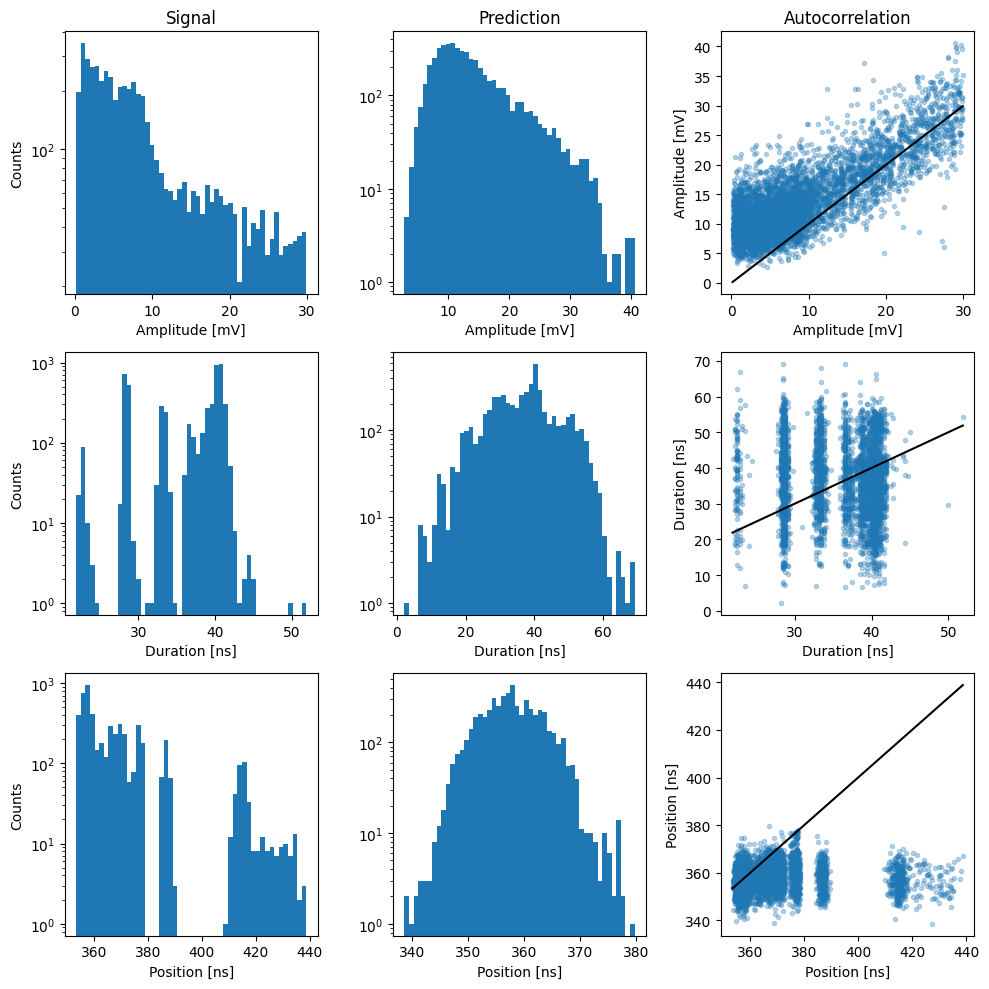

In [27]:
# plot distribution histograms for labels and predictions + auto-correlation for test signals > 30 mV 

xdata1 = np.linspace(min(signal_A_below),max(signal_A_below),1000)
xdata2 = np.linspace(min(signal_dur_below),max(signal_dur_below),1000)
xdata3 = np.linspace(min(signal_pos_below),max(signal_pos_below),1000)

fig, ax = plt.subplots(3,3, figsize=(10,10))

ax[0,0].hist(signal_A_below, bins = 50, log = True)
ax[0,1].hist(prediction_A_below, bins = 50, log = True)
ax[0,2].plot(signal_A_below, prediction_A_below, linestyle = 'None', marker = '.', alpha=0.3)
ax[0,2].plot(xdata1,xdata1,color="k")
ax[0,0].set_ylabel("Counts")

ax[1,0].hist(signal_dur_below, bins = 50, log = True)
ax[1,1].hist(prediction_dur_below, bins = 50, log = True)
ax[1,2].plot(signal_dur_below, prediction_dur_below, linestyle = 'None', marker = '.', alpha=0.3)
ax[1,2].plot(xdata2,xdata2,color="k")
ax[1,0].set_ylabel("Counts")

ax[2,0].hist(signal_pos_below, bins = 50, log = True)
ax[2,1].hist(prediction_pos_below, bins = 50, log = True)
ax[2,2].plot(signal_pos_below, prediction_pos_below, linestyle = 'None', marker = '.', alpha=0.3)
ax[2,2].plot(xdata3,xdata3,color="k")
ax[2,0].set_ylabel("Counts")

ax[0,0].set_title("Signal")
ax[0,1].set_title("Prediction")
ax[0,2].set_title("Autocorrelation")
ax[0,0].set_xlabel("Amplitude [mV]")
ax[0,1].set_xlabel("Amplitude [mV]")
ax[0,2].set_xlabel("Amplitude [mV]")
ax[0,2].set_ylabel("Amplitude [mV]")

ax[1,0].set_xlabel("Duration [ns]")
ax[1,1].set_xlabel("Duration [ns]")
ax[1,2].set_xlabel("Duration [ns]")
ax[1,2].set_ylabel("Duration [ns]")

ax[2,0].set_xlabel("Position [ns]")
ax[2,1].set_xlabel("Position [ns]")
ax[2,2].set_xlabel("Position [ns]")
ax[2,2].set_ylabel("Position [ns]")


fig.tight_layout()

fig.savefig("performance_below_threas.png")